In [4]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import
from utils import *
import sys
import os
import gc



def load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()

from clust_huge_amp import *
# Subset the data

# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)


del Y

# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the RDS file

import pandas as pd
fh_processed=pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox/baselinagefamh.csv')
len(fh_processed)


pce_df_subset = fh_processed.iloc[0:10000].reset_index(drop=True)
sex=pce_df_subset['sex'].values
G_with_sex = np.column_stack([G_100k, sex]) 

import torch
import numpy as np
import cProfile
import pstats
from pstats import SortKey


    
    # Path to your total fit model
from clust_huge_amp_fixedPhi import *
total_fit_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_model_W0.0001_fulldata_sexspecific.pt'
total_checkpoint = torch.load(total_fit_path, map_location='cpu')
phi_total = total_checkpoint['model_state_dict']['phi'].cpu().numpy()  # shape: (K, D, T)
psi_total = total_checkpoint['model_state_dict']['psi'].cpu().numpy()  # shape: (K, D, T)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50262/2155297514.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50262/2155297514.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('/Users/sarahurbut/Library

In [8]:
disease_names=essentials['disease_names']

In [11]:
prevalence_logit=essentials['prevalence_t']

In [22]:
total_fit_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_model_W0.0001_fulldata_sexspecific.pt'
total_checkpoint = torch.load(total_fit_path, map_location='cpu')
phi = total_checkpoint['model_state_dict']['phi'].cpu().numpy()  # shape: (K, D, T)
psi_total = total_checkpoint['model_state_dict']['psi'].cpu().numpy()  # shape: (K, D, T)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50262/3473257525.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  total_checkpoint = torch.load(total_fit_path,

In [55]:
import numpy as np
import pandas as pd
import torch
import argparse
import os
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
n_top=10

phi_centered = np.zeros_like(phi)
for k in range(phi.shape[0]):
    for d in range(phi.shape[1]):
        phi_centered[k, d, :] = phi[k, d, :] - logit_prev_t[d, :]


In [63]:
import pandas as pd
import numpy as np
checkpoint = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_model_W0.0001_fulldata_sexspecific.pt', map_location='cpu')

def get_diseases_by_cluster_assignment(phi_centered, disease_names, cluster_assignments, top_within_cluster=3):
    """
    Extract diseases for each signature based on actual cluster assignments
    """
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    results = []
    
    # Get unique signatures/clusters
    unique_clusters = np.unique(cluster_assignments)
    
    for k in unique_clusters:
        # Find diseases assigned to this cluster
        cluster_disease_indices = np.where(cluster_assignments == k)[0]
        
        print(f"\n=== Signature {k} ===")
        print(f"Total diseases in cluster: {len(cluster_disease_indices)}")
        
        # Get phi scores for diseases in this cluster
        cluster_scores = []
        for idx in cluster_disease_indices:
            avg_effect = phi_avg[k, idx]
            temporal_std = np.std(phi_centered[k, idx, :])
            odds_ratio = np.exp(avg_effect)
            
            # Handle disease name indexing
            try:
                if isinstance(disease_names, pd.DataFrame):
                    disease_name = disease_names.iloc[idx, 0]
                elif isinstance(disease_names, pd.Series):
                    disease_name = disease_names.iloc[idx]
                elif isinstance(disease_names, list):
                    disease_name = disease_names[idx]
                else:
                    disease_name = str(disease_names[idx])
            except (IndexError, KeyError):
                disease_name = f"Disease_{idx}"
            
            # Clean up disease name
            if isinstance(disease_name, str):
                disease_name = disease_name.strip()
            
            cluster_scores.append({
                'signature': k,
                'disease_idx': idx,
                'disease': disease_name,
                'avg_effect': avg_effect,
                'odds_ratio': odds_ratio,
                'temporal_std': temporal_std
            })
        
        # Sort by odds ratio (descending) within this cluster
        cluster_scores = sorted(cluster_scores, key=lambda x: x['odds_ratio'], reverse=True)
        
        # Print all diseases in cluster, highlight top ones
        for i, disease_data in enumerate(cluster_scores):
            marker = "★" if i < top_within_cluster else " "
            print(f"  {marker} {disease_data['disease']}: effect={disease_data['avg_effect']:.3f} (OR={disease_data['odds_ratio']:.2f}), std={disease_data['temporal_std']:.3f}")
        
        results.extend(cluster_scores)
    
    return pd.DataFrame(results)

# Run with actual cluster assignments
cluster_assignments=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_clusters_400k.pt')
# This should be the actual assignments
results_df = get_diseases_by_cluster_assignment(phi_centered, disease_names, cluster_assignments, top_within_cluster=3)

# Create summary table using actual cluster memberships
def create_cluster_summary(results_df, top_n=3):
    """
    Create summary showing top N diseases per cluster
    """
    summary = []
    
    for k in sorted(results_df['signature'].unique()):
        sig_data = results_df[results_df['signature'] == k].head(top_n)
        
        # Format the top diseases
        disease_strings = []
        for _, row in sig_data.iterrows():
            disease_strings.append(f"{row['disease']} ({row['odds_ratio']:.2f})")
        
        # Count total diseases in cluster
        total_diseases = len(results_df[results_df['signature'] == k])
        
        summary.append({
            'signature': k,
            'total_diseases': total_diseases,
            'top_diseases': ', '.join(disease_strings),
            'clinical_domain': ''  # Fill manually based on the diseases
        })
    
    return pd.DataFrame(summary)

# Generate summary
summary_df = create_cluster_summary(results_df, top_n=3)
print("\n" + "="*80)
print("CLUSTER-BASED SUMMARY TABLE:")
print("="*80)
print(summary_df.to_string(index=False))


=== Signature 0 ===
Total diseases in cluster: 16
  ★ Atrial fibrillation and flutter: effect=1.619 (OR=5.05), std=0.585
  ★ Heart failure NOS: effect=1.466 (OR=4.33), std=0.337
  ★ Cardiomegaly: effect=1.275 (OR=3.58), std=0.364
    Paroxysmal ventricular tachycardia: effect=1.270 (OR=3.56), std=0.113
    Aortic valve disease: effect=1.262 (OR=3.53), std=0.138
    Pleurisy; pleural effusion: effect=1.259 (OR=3.52), std=0.422
    Congestive heart failure (CHF) NOS: effect=1.241 (OR=3.46), std=0.284
    Congenital anomalies of great vessels: effect=1.172 (OR=3.23), std=0.199
    Mitral valve disease: effect=1.167 (OR=3.21), std=0.287
    Pericarditis: effect=1.145 (OR=3.14), std=0.081
    Left bundle branch block: effect=1.139 (OR=3.12), std=0.139
    Paroxysmal supraventricular tachycardia: effect=1.095 (OR=2.99), std=0.202
    Rheumatic disease of the heart valves: effect=1.077 (OR=2.94), std=0.195
    Disease of tricuspid valve: effect=1.029 (OR=2.80), std=0.243
    Other forms of c

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50262/324049620.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/Users/sarahurbut/Lib

In [96]:

def plot_gamma_heatmap_with_stats(base_dir, batch_size=10000, n_batches=10, output_path=None, 
                              figsize=(20, 16), cmap='RdBu_r', prs_names_file=None):
    """
    Create a heatmap of gamma (genetic influences on signatures) using data from all batches,
    with significance testing and PRS names.
    
    Parameters:
    -----------
    base_dir : str
        Base directory containing the batch folders
    batch_size : int
        Size of each batch
    n_batches : int
        Number of batches to process
    output_path : str, optional
        Path to save the figure
    figsize : tuple
        Figure size (width, height) in inches
    cmap : str
        Colormap for the heatmap
    prs_names_file : str, optional
        Path to CSV file containing PRS names
    """
    import numpy as np
    import torch
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from scipy import stats
    
    # Load PRS names if file is provided
    if prs_names_file:
        try:
            prs_df = pd.read_csv(prs_names_file)
            print(f"Loaded {len(prs_df)} PRS names")
            prs_names = prs_df.iloc[:, 0].tolist()
        except Exception as e:
            print(f"Error loading PRS names: {e}")
            prs_names = None
    else:
        prs_names = None
    
    # Storage for gamma values from each batch
    all_gammas = []
    
    # Process each batch
    print("Loading gamma values from all batches...")
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        model_path = f'{base_dir}/output_{start_idx}_{end_idx}/model.pt'
        
        try:
            model_data = torch.load(model_path, map_location='cpu')
            
            # Extract gamma
            if 'model_state_dict' in model_data and 'gamma' in model_data['model_state_dict']:
                gamma = model_data['model_state_dict']['gamma'].detach().cpu().numpy()
            elif 'gamma' in model_data:
                gamma = model_data['gamma']
                if torch.is_tensor(gamma):
                    gamma = gamma.detach().cpu().numpy()
            else:
                print(f"Warning: Could not find gamma in batch {batch}")
                continue
                
            all_gammas.append(gamma)
            print(f"Loaded gamma from batch {batch+1} with shape {gamma.shape}")
            
        except FileNotFoundError:
            print(f"Warning: Could not find model file for batch {batch}")
            break
        except Exception as e:
            print(f"Error processing batch {batch}: {e}")
            continue
    
    if not all_gammas:
        print("No gamma values found!")
        return None
    
    # Stack all gammas
    gamma_stack = np.stack(all_gammas)
    
    # Calculate mean and standard error
    gamma_mean = np.mean(gamma_stack, axis=0)
    gamma_sem = np.std(gamma_stack, axis=0) / np.sqrt(len(all_gammas))
    
    # Perform t-tests against null hypothesis (gamma = 0)
    t_stats = gamma_mean / gamma_sem
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=len(all_gammas)-1))
    
    # Bonferroni correction
    bonferroni_threshold = 0.05 / (36)  # Adjust based on total number of tests
    print(f"Using Bonferroni threshold: {bonferroni_threshold:.2e}")
    
    # Get dimensions and create labels
    P, K = gamma_mean.shape
    
    # Use provided PRS names or create generic ones
    if prs_names is not None and len(prs_names) == P:
        row_labels = prs_names
    else:
        row_labels = [f"PRS_{i+1}" for i in range(P)]
    
    col_labels = [f"Signature {k}" for k in range(K)]
    
    # Create annotations (just stars for significance)
    annotations = np.empty_like(gamma_mean, dtype=object)
    for i in range(P):
        for j in range(K):
            p_val = p_values[i, j]
            if p_val < bonferroni_threshold:
                annotations[i, j] = '*'
            else:
                annotations[i, j] = ''
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Create heatmap
    ax = sns.heatmap(gamma_mean, 
                    annot=annotations,
                    fmt='',
                    cmap=cmap,
                    center=0,
                    linewidths=0.5,
                    linecolor='gray',
                    xticklabels=col_labels,
                    yticklabels=row_labels,
                    cbar_kws={'label': 'Genetic Effect Size'},
                    annot_kws={'size': 12, 'weight': 'bold'})
    
    # Customize appearance
    plt.title("PRS-State Associations with Significance Annotations", 
             pad=20, size=14)
    
    # Rotate y-axis labels for better readability
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Saved heatmap to {output_path}")
        plt.close()
    else:
        plt.show()
    
    # Return the computed statistics
    return {
        'gamma_mean': gamma_mean,
        'gamma_sem': gamma_sem,
        'p_values': p_values,
        'significant': p_values < bonferroni_threshold
    }


Loaded 36 PRS names
Loading gamma values from all batches...
Loaded gamma from batch 1 with shape (36, 21)
Loaded gamma from batch 2 with shape (36, 21)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50262/2395841165.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load(model_path, map_loca

Loaded gamma from batch 3 with shape (36, 21)
Loaded gamma from batch 4 with shape (36, 21)
Loaded gamma from batch 5 with shape (36, 21)
Loaded gamma from batch 6 with shape (36, 21)
Loaded gamma from batch 7 with shape (36, 21)
Loaded gamma from batch 8 with shape (36, 21)
Loaded gamma from batch 9 with shape (36, 21)
Loaded gamma from batch 10 with shape (36, 21)
Using Bonferroni threshold: 1.39e-03


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50262/2395841165.py:89: RuntimeWarning: invalid value encountered in divide
  t_stats = gamma_mean / gamma_sem


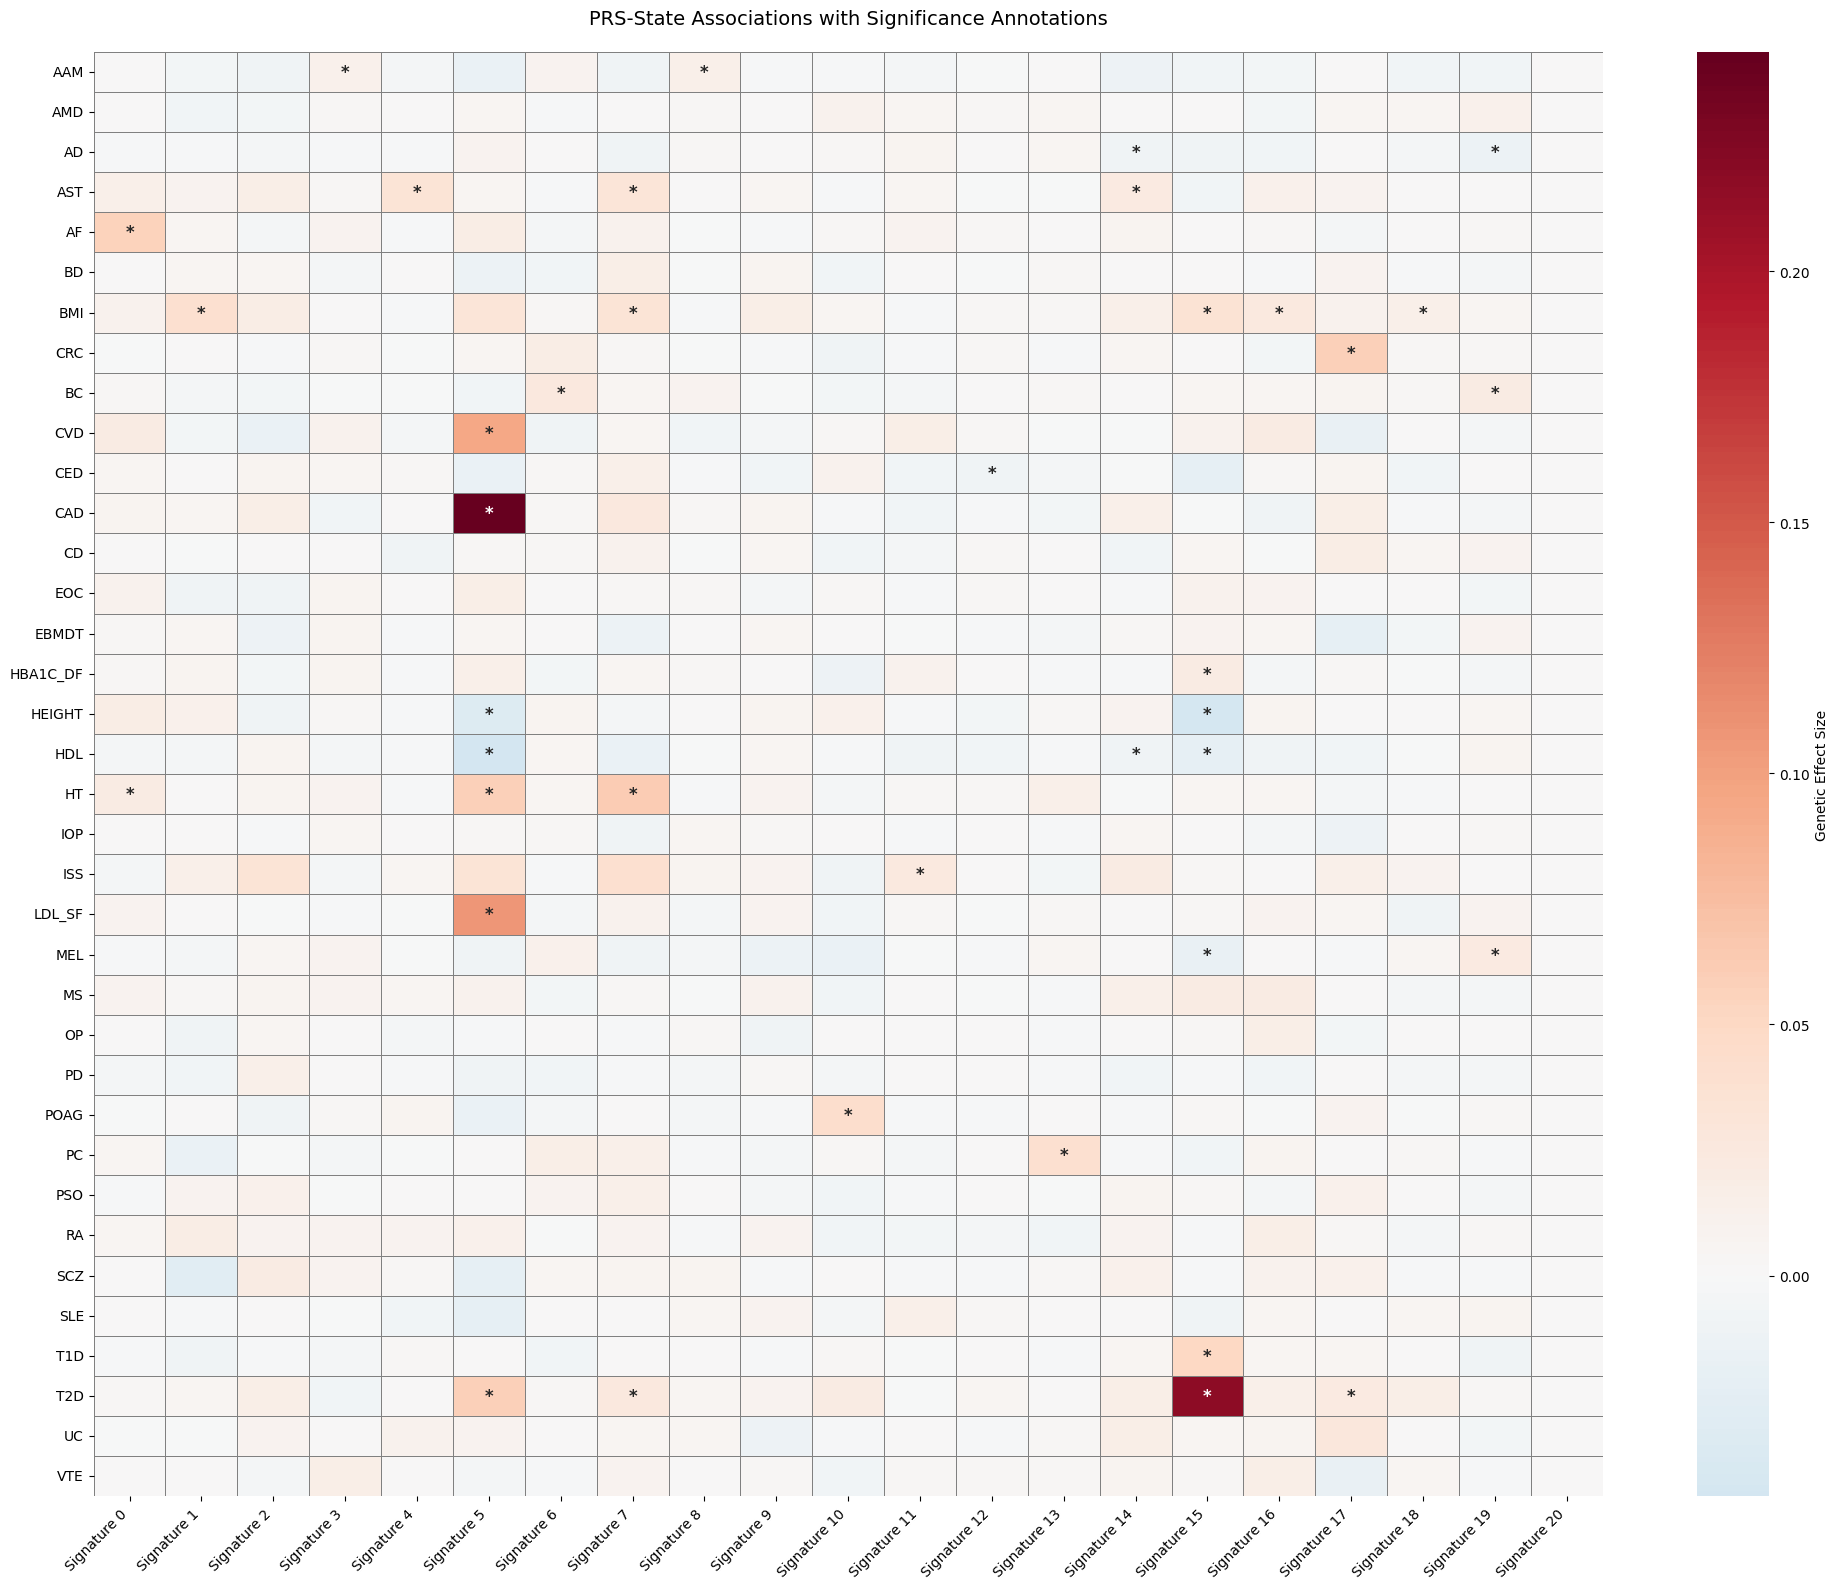

In [101]:
results=plot_gamma_heatmap_with_stats('/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/', batch_size=10000, 
n_batches=10, output_path=None, figsize=(20, 16), cmap='RdBu_r', prs_names_file='/Users/sarahurbut/aladynoulli2/pyScripts/prs_names.csv')

In [102]:
significant_matrix = results['significant']  # shape: (n_PRS, n_signatures)

# Count total significant associations
n_significant = significant_matrix.sum()
total_tests = significant_matrix.size
significance_rate = n_significant / total_tests

print(f"Number of significant PRS-signature associations: {n_significant} out of {total_tests} ({significance_rate:.2%})")

Number of significant PRS-signature associations: 39 out of 756 (5.16%)


In [103]:
prs_df=pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/prs_names.csv')

print(f"Loaded {len(prs_df)} PRS names")
prs_names = prs_df.iloc[:, 0].tolist()

Loaded 36 PRS names


In [104]:
import numpy as np
row_labels=prs_names
col_labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]


gamma_mean = results['gamma_mean']
significant = results['significant']
# Get indices of significant associations
sig_indices = np.argwhere(significant_matrix)
for i, j in sig_indices:
    print(f"PRS: {row_labels[i]}, Signature: {col_labels[j]}, Effect: {gamma_mean[i, j]:.3f}")

PRS: AAM, Signature: 3, Effect: 0.012
PRS: AAM, Signature: 8, Effect: 0.014
PRS: AD, Signature: 14, Effect: -0.011
PRS: AD, Signature: 19, Effect: -0.014
PRS: AST, Signature: 4, Effect: 0.033
PRS: AST, Signature: 7, Effect: 0.031
PRS: AST, Signature: 14, Effect: 0.022
PRS: AF, Signature: 0, Effect: 0.055
PRS: BMI, Signature: 1, Effect: 0.039
PRS: BMI, Signature: 7, Effect: 0.033
PRS: BMI, Signature: 15, Effect: 0.037
PRS: BMI, Signature: 16, Effect: 0.024
PRS: BMI, Signature: 18, Effect: 0.015
PRS: CRC, Signature: 17, Effect: 0.057
PRS: BC, Signature: 6, Effect: 0.027
PRS: BC, Signature: 19, Effect: 0.021
PRS: CVD, Signature: 5, Effect: 0.095
PRS: CED, Signature: 12, Effect: -0.009
PRS: CAD, Signature: 5, Effect: 0.244
PRS: HBA1C_DF, Signature: 15, Effect: 0.021
PRS: HEIGHT, Signature: 5, Effect: -0.033
PRS: HEIGHT, Signature: 15, Effect: -0.042
PRS: HDL, Signature: 5, Effect: -0.044
PRS: HDL, Signature: 14, Effect: -0.011
PRS: HDL, Signature: 15, Effect: -0.020
PRS: HT, Signature: 0, 

In [105]:
import pandas as pd
sig_indices = np.argwhere(significant)
table = []
for i, j in sig_indices:
    table.append({
        "PRS": row_labels[i],
        "Signature": col_labels[j],
        "Effect Size (γ)": gamma_mean[i, j]
    })

df = pd.DataFrame(table)
print(df)
# Optionally, save 

         PRS  Signature  Effect Size (γ)
0        AAM          3         0.012303
1        AAM          8         0.014450
2         AD         14        -0.011354
3         AD         19        -0.013604
4        AST          4         0.032847
5        AST          7         0.031190
6        AST         14         0.022415
7         AF          0         0.055401
8        BMI          1         0.038976
9        BMI          7         0.033144
10       BMI         15         0.036907
11       BMI         16         0.024103
12       BMI         18         0.014980
13       CRC         17         0.057382
14        BC          6         0.026557
15        BC         19         0.021043
16       CVD          5         0.095118
17       CED         12        -0.009371
18       CAD          5         0.243683
19  HBA1C_DF         15         0.020543
20    HEIGHT          5        -0.033242
21    HEIGHT         15        -0.041867
22       HDL          5        -0.043940
23       HDL    

In [ ]:


# Store predictions for each age
age_predictions = {}

#for age_offset in range(0, 10):  # Ages 0-10 years after enrollment
for age_offset in range(7, 10):  # Ages 0-10 years after enrollment
    print(f"\n=== Predicting for age offset {age_offset} years ===")

    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.backends.cudnn.deterministic = True



    model = AladynSurvivalFixedPhi(
        N=Y_100k.shape[0],
        D=Y_100k.shape[1],
        T=Y_100k.shape[2],
        K=20,
        P=G_with_sex.shape[1],
        G=G_with_sex,
        Y=Y_100k,
        R=0,
        W=0.0001,
        prevalence_t=essentials['prevalence_t'],
        init_sd_scaler=1e-1,
        genetic_scale=1,
        pretrained_phi=phi_total,
        pretrained_psi=psi_total,
        signature_references=signature_refs,
        healthy_reference=True,
        disease_names=essentials['disease_names']
    )

    if np.allclose(model.phi.cpu().numpy(), phi_total):
        print("phi matches phi_total!")
    else:
        print("phi does NOT match phi_total!")

    if np.allclose(model.psi.cpu().numpy(), psi_total):
        print("psi matches psi_total!")
    else:
        print("psi does NOT match psi_total!")



     # Create age-specific event times
    E_age_specific = E_100k.clone()
    pce_df_subset = fh_processed.iloc[0:10000].reset_index(drop=True)

     
    # Initialize tracking variables for this age offset
    total_times_changed = 0
    max_cap_applied = 0
    min_cap_applied = float('inf')

    
    for patient_idx, row in enumerate(pce_df_subset.itertuples()):
        if patient_idx >= E_age_specific.shape[0]:
            break
            
        # Current age = enrollment age + age_offset
        current_age = row.age + age_offset
        
        # Time since age 30 for this current age
        time_since_30 = max(0, current_age - 30)

        max_cap_applied = max(max_cap_applied, time_since_30)
        min_cap_applied = min(min_cap_applied, time_since_30)
        
        # Store original times for this patient
        original_times = E_age_specific[patient_idx, :].clone()
        
        # Cap event times to current age
        E_age_specific[patient_idx, :] = torch.minimum(
            E_age_specific[patient_idx, :],
            torch.full_like(E_age_specific[patient_idx, :], time_since_30)
        )

        times_changed = torch.sum(E_age_specific[patient_idx, :] != original_times).item()
        total_times_changed += times_changed
    
    # Print censoring verification
    print(f"Censoring verification for age offset {age_offset}:")
    print(f"  Total event times changed: {total_times_changed}")
    print(f"  Max cap applied: {max_cap_applied:.1f}")
    print(f"  Min cap applied: {min_cap_applied:.1f}")
    
    # Check a few specific patients
    test_patients = [0, 1, 100]  # Check patients 0, 1, and 100
    for test_idx in test_patients:
        if test_idx < len(pce_df_subset):
            row = pce_df_subset.iloc[test_idx]
            enrollment_age = row.age
            current_age = enrollment_age + age_offset
            expected_cap = max(0, current_age - 30)
            
            # Check max value in this patient's event times
            max_time = torch.max(E_age_specific[test_idx, :]).item()
            
            print(f"  Patient {test_idx}: enrollment={enrollment_age:.0f}, current={current_age:.0f}, "
                  f"cap={expected_cap:.1f}, max_event_time={max_time:.1f}")
            
            # Verify cap was applied correctly
            if max_time > expected_cap + 0.01:  # Small tolerance
                print(f"    WARNING: Max time {max_time:.1f} exceeds cap {expected_cap:.1f}!")
    
  
    
    # Train model for this specific age
    print(f"Training model for age offset {age_offset}...")
    profiler = cProfile.Profile()
    profiler.enable()
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.backends.cudnn.deterministic = True
    
    history_new = model.fit(
        E_age_specific, 
        num_epochs=200, 
        learning_rate=1e-1, 
        lambda_reg=1e-2
    )
    
    profiler.disable()
    stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
    
    

    plot_training_evolution(history_new)

    profiler.disable()
    stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
    stats.print_stats(20)
    
    # Get predictions for this age
    with torch.no_grad():
        pi, _, _ = model.forward()
        
        # Save age-specific predictions
        filename = f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_fixedphi_age_offset_{age_offset}_sex_0_10000_try2.pt"
        torch.save(pi, filename)
       
        print(f"Saved predictions to {filename}")

    filename = f"/Users/sarahurbut/Library/CloudStorage/Dropbox/model_enroll_fixedphi_age_offset_{age_offset}_sex_0_10000_try2.pt"
    torch.save({
        'model_state_dict': model.state_dict(),
        'E':E_age_specific,
        #'phi': model.phi,
        #'Y': model.Y,
        'prevalence_t': model.prevalence_t,
        'logit_prevalence_t': model.logit_prev_t,
        #'G': model.G,
    }, filename)
    print(f"Saved model to {filename}")
        # Store in dictionary for potential analysis
        
    
    # Clean up to free memory
    del pi
    del model
    del E_age_specific
    torch.cuda.empty_cache() if torch.cuda.is_available() else None


In [ ]:





import torch
import numpy as np
import cProfile
import pstats
from pstats import SortKey

# Store predictions for each age
age_predictions = {}

for age_offset in range(0, 10):  # Ages 0-10 years after enrollment
    print(f"\n=== Predicting for age offset {age_offset} years ===")
    
    # Set seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    # Initialize fresh model for this age
    suppress_stdout()
    model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
        N=Y_100k.shape[0],
        D=Y_100k.shape[1],
        T=Y_100k.shape[2],
        K=20,
        P=G_with_sex.shape[1],
        init_sd_scaler=1e-1,
        G=G_with_sex,
        Y=Y_100k,
        genetic_scale=1,
        W=0.0001,
        R=0,
        prevalence_t=essentials['prevalence_t'],
        signature_references=signature_refs,
        healthy_reference=True,
        disease_names=essentials['disease_names']
    )
   

       # Reset seeds for parameter initialization
    torch.manual_seed(0)
    np.random.seed(0)
    
    # Load and set initial parameters
    initial_psi = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_psi_400k.pt')
    initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_clusters_400k.pt')
    model.initialize_params(true_psi=initial_psi)
    enable_stdout()
    model.clusters = initial_clusters




    # Create age-specific event times
    E_age_specific = E_100k.clone()
    pce_df_subset = fh_processed.iloc[0:10000].reset_index(drop=True)

     
    # Initialize tracking variables for this age offset
    total_times_changed = 0
    max_cap_applied = 0
    min_cap_applied = float('inf')

    
    for patient_idx, row in enumerate(pce_df_subset.itertuples()):
        if patient_idx >= E_age_specific.shape[0]:
            break
            
        # Current age = enrollment age + age_offset
        current_age = row.age + age_offset
        
        # Time since age 30 for this current age
        time_since_30 = max(0, current_age - 30)

        max_cap_applied = max(max_cap_applied, time_since_30)
        min_cap_applied = min(min_cap_applied, time_since_30)
        
        # Store original times for this patient
        original_times = E_age_specific[patient_idx, :].clone()
        
        # Cap event times to current age
        E_age_specific[patient_idx, :] = torch.minimum(
            E_age_specific[patient_idx, :],
            torch.full_like(E_age_specific[patient_idx, :], time_since_30)
        )

        times_changed = torch.sum(E_age_specific[patient_idx, :] != original_times).item()
        total_times_changed += times_changed
    
    # Print censoring verification
    print(f"Censoring verification for age offset {age_offset}:")
    print(f"  Total event times changed: {total_times_changed}")
    print(f"  Max cap applied: {max_cap_applied:.1f}")
    print(f"  Min cap applied: {min_cap_applied:.1f}")
    
    # Check a few specific patients
    test_patients = [0, 1, 100]  # Check patients 0, 1, and 100
    for test_idx in test_patients:
        if test_idx < len(pce_df_subset):
            row = pce_df_subset.iloc[test_idx]
            enrollment_age = row.age
            current_age = enrollment_age + age_offset
            expected_cap = max(0, current_age - 30)
            
            # Check max value in this patient's event times
            max_time = torch.max(E_age_specific[test_idx, :]).item()
            
            print(f"  Patient {test_idx}: enrollment={enrollment_age:.0f}, current={current_age:.0f}, "
                  f"cap={expected_cap:.1f}, max_event_time={max_time:.1f}")
            
            # Verify cap was applied correctly
            if max_time > expected_cap + 0.01:  # Small tolerance
                print(f"    WARNING: Max time {max_time:.1f} exceeds cap {expected_cap:.1f}!")
    
  
    
    # Train model for this specific age
    print(f"Training model for age offset {age_offset}...")
    profiler = cProfile.Profile()
    profiler.enable()
    
    suppress_stdout()
    history_new = model.fit(
        E_age_specific, 
        num_epochs=200, 
        learning_rate=1e-1, 
        lambda_reg=1e-2
    )
    
    profiler.disable()
    stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
    
    enable_stdout()

    plot_training_evolution(history_new)

    profiler.disable()
    stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
    stats.print_stats(20)
    
    # Get predictions for this age
    with torch.no_grad():
        pi, _, _ = model.forward()
        
        # Save age-specific predictions
        filename = f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age_offset_{age_offset}_sex_0_10000_try2.pt"
        torch.save(pi, filename)
       
        print(f"Saved predictions to {filename}")

    filename = f"/Users/sarahurbut/Library/CloudStorage/Dropbox/model_enroll_age_offset_{age_offset}_sex_0_10000_try2.pt"
    torch.save({
        'model_state_dict': model.state_dict(),
        'E':E_age_specific,
        #'phi': model.phi,
        #'Y': model.Y,
        'prevalence_t': model.prevalence_t,
        'logit_prevalence_t': model.logit_prev_t,
        #'G': model.G,
    }, filename)
    print(f"Saved model to {filename}")
        # Store in dictionary for potential analysis
        
    
    # Clean up to free memory
    del pi
    del model
    del E_age_specific
    torch.cuda.empty_cache() if torch.cuda.is_available() else None



    ## now do with fixed phi?


In [ ]:

import torch
import numpy as np
import cProfile
import pstats
from pstats import SortKey


    
    # Path to your total fit model
from clust_huge_amp_fixedPhi import *
total_fit_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_model_W0.0001_fulldata_sexspecific.pt'
total_checkpoint = torch.load(total_fit_path, map_location='cpu')
phi_total = total_checkpoint['model_state_dict']['phi'].cpu().numpy()  # shape: (K, D, T)
psi_total = total_checkpoint['model_state_dict']['psi'].cpu().numpy()  # shape: (K, D, T)



# Store predictions for each age
age_predictions = {}

for age_offset in range(0, 10):  # Ages 0-10 years after enrollment
    print(f"\n=== Predicting for age offset {age_offset} years ===")

    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.backends.cudnn.deterministic = True



    model = AladynSurvivalFixedPhi(
        N=Y_100k.shape[0],
        D=Y_100k.shape[1],
        T=Y_100k.shape[2],
        K=20,
        P=G_with_sex.shape[1],
        G=G_with_sex,
        Y=Y_100k,
        R=0,
        W=0.0001,
        prevalence_t=essentials['prevalence_t'],
        init_sd_scaler=1e-1,
        genetic_scale=1,
        pretrained_phi=phi_total,
        pretrained_psi=psi_total,
        signature_references=signature_refs,
        healthy_reference=True,
        disease_names=essentials['disease_names']
    )

    if np.allclose(model.phi.cpu().numpy(), phi_total):
        print("phi matches phi_total!")
    else:
        print("phi does NOT match phi_total!")

    if np.allclose(model.psi.cpu().numpy(), psi_total):
        print("psi matches psi_total!")
    else:
        print("psi does NOT match psi_total!")



     # Create age-specific event times
    E_age_specific = E_100k.clone()
    pce_df_subset = fh_processed.iloc[0:10000].reset_index(drop=True)

     
    # Initialize tracking variables for this age offset
    total_times_changed = 0
    max_cap_applied = 0
    min_cap_applied = float('inf')

    
    for patient_idx, row in enumerate(pce_df_subset.itertuples()):
        if patient_idx >= E_age_specific.shape[0]:
            break
            
        # Current age = enrollment age + age_offset
        current_age = row.age + age_offset
        
        # Time since age 30 for this current age
        time_since_30 = max(0, current_age - 30)

        max_cap_applied = max(max_cap_applied, time_since_30)
        min_cap_applied = min(min_cap_applied, time_since_30)
        
        # Store original times for this patient
        original_times = E_age_specific[patient_idx, :].clone()
        
        # Cap event times to current age
        E_age_specific[patient_idx, :] = torch.minimum(
            E_age_specific[patient_idx, :],
            torch.full_like(E_age_specific[patient_idx, :], time_since_30)
        )

        times_changed = torch.sum(E_age_specific[patient_idx, :] != original_times).item()
        total_times_changed += times_changed
    
    # Print censoring verification
    print(f"Censoring verification for age offset {age_offset}:")
    print(f"  Total event times changed: {total_times_changed}")
    print(f"  Max cap applied: {max_cap_applied:.1f}")
    print(f"  Min cap applied: {min_cap_applied:.1f}")
    
    # Check a few specific patients
    test_patients = [0, 1, 100]  # Check patients 0, 1, and 100
    for test_idx in test_patients:
        if test_idx < len(pce_df_subset):
            row = pce_df_subset.iloc[test_idx]
            enrollment_age = row.age
            current_age = enrollment_age + age_offset
            expected_cap = max(0, current_age - 30)
            
            # Check max value in this patient's event times
            max_time = torch.max(E_age_specific[test_idx, :]).item()
            
            print(f"  Patient {test_idx}: enrollment={enrollment_age:.0f}, current={current_age:.0f}, "
                  f"cap={expected_cap:.1f}, max_event_time={max_time:.1f}")
            
            # Verify cap was applied correctly
            if max_time > expected_cap + 0.01:  # Small tolerance
                print(f"    WARNING: Max time {max_time:.1f} exceeds cap {expected_cap:.1f}!")
    
  
    
    # Train model for this specific age
    print(f"Training model for age offset {age_offset}...")
    profiler = cProfile.Profile()
    profiler.enable()
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.backends.cudnn.deterministic = True
    suppress_stdout()
    history_new = model.fit(
        E_age_specific, 
        num_epochs=200, 
        learning_rate=1e-1, 
        lambda_reg=1e-2
    )
    
    profiler.disable()
    stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
    
    enable_stdout()

    plot_training_evolution(history_new)

    profiler.disable()
    stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
    stats.print_stats(20)
    
    # Get predictions for this age
    with torch.no_grad():
        pi, _, _ = model.forward()
        
        # Save age-specific predictions
        filename = f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_fixedphi_age_offset_{age_offset}_sex_0_10000_try2.pt"
        torch.save(pi, filename)
       
        print(f"Saved predictions to {filename}")

    filename = f"/Users/sarahurbut/Library/CloudStorage/Dropbox/model_enroll_fixedphi_age_offset_{age_offset}_sex_0_10000_try2.pt"
    torch.save({
        'model_state_dict': model.state_dict(),
        'E':E_age_specific,
        #'phi': model.phi,
        #'Y': model.Y,
        'prevalence_t': model.prevalence_t,
        'logit_prevalence_t': model.logit_prev_t,
        #'G': model.G,
    }, filename)
    print(f"Saved model to {filename}")
        # Store in dictionary for potential analysis
        
    
    # Clean up to free memory
    del pi
    del model
    del E_age_specific
    torch.cuda.empty_cache() if torch.cuda.is_available() else None


In [ ]:
def plot_training_evolution(history_tuple):
    losses, gradient_history = history_tuple
    
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    plt.yscale('log')
    plt.legend()
    
    # Plot lambda gradients
    plt.subplot(1, 3, 2)
    lambda_norms = [torch.norm(g).item() for g in gradient_history['lambda_grad']]
    plt.plot(lambda_norms, label='Lambda gradients')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.title('Lambda Gradient Evolution')
    plt.legend()
    
    # Plot phi gradients
    #plt.subplot(1, 3, 3)
    #phi_norms = [torch.norm(g).item() for g in gradient_history['phi_grad']]
    #plt.plot(phi_norms, label='Phi gradients')
    #plt.yscale('log')
    #plt.xlabel('Epoch')
    #plt.ylabel('Gradient norm')
    #plt.title('Phi Gradient Evolution')
    #plt.legend()
    
    plt.tight_layout()
    plt.show()
    
plot_training_evolution(history_new)

In [ ]:
import matplotlib.pyplot as plt

k = 5
d = 112
T = all_phis.shape[-1]

phi_curves = all_phis[:, k, d, :]  # shape: (n_batches, T)
mean_phi = phi_curves.mean(axis=0)
se_phi = phi_curves.std(axis=0) / np.sqrt(all_phis.shape[0])
phi_total_curve = phi_total[k, d, :]

plt.figure(figsize=(10, 5))
for b in range(all_phis.shape[0]):
    plt.plot(phi_curves[b], color='gray', alpha=0.3, linewidth=0.7)
plt.plot(mean_phi, color='blue', label='Batch mean')
plt.fill_between(np.arange(T), mean_phi - se_phi, mean_phi + se_phi, color='blue', alpha=0.2, label='Batch SE')
plt.plot(phi_total_curve, color='red', linewidth=2, label='Total fit')
plt.title(f'Phi curves for K={k}, d={d} across batches and total fit')
plt.xlabel('Time')
plt.ylabel('phi')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import torch
import numpy as np

# Path to your batch model files
base_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/model_enroll_age/'
n_batches = 10  # or however many you have
phi_list = []

for age_offset in range(n_batches):
    filename = f"{base_path}model_enroll_age_offset_{age_offset}_sex_0_10000_try2.pt"
    checkpoint = torch.load(filename, map_location='cpu')
    # If phi is in the state dict:
    phi = checkpoint['model_state_dict']['phi'].cpu().numpy()  # shape: (K, D, T)
    phi_list.append(phi)

all_phis = np.stack(phi_list, axis=0)  # shape: (n_batches, K, D, T)

In [ ]:
import matplotlib.pyplot as plt

k = 5
d = 112
T = all_phis.shape[-1]

phi_curves = all_phis[:, k, d, :]  # shape: (n_batches, T)
mean_phi = phi_curves.mean(axis=0)
mean_phi2=mean_phi
se_phi = phi_curves.std(axis=0) / np.sqrt(all_phis.shape[0])
phi_total_curve = phi_total[k, d, :]

plt.figure(figsize=(10, 5))
for b in range(all_phis.shape[0]):
    plt.plot(phi_curves[b], color='gray', alpha=0.3, linewidth=0.7)
plt.plot(mean_phi, color='blue', label='Batch mean')
plt.fill_between(np.arange(T), mean_phi - se_phi, mean_phi + se_phi, color='blue', alpha=0.2, label='Batch SE')
plt.plot(phi_total_curve, color='red', linewidth=2, label='Total fit')
plt.title(f'Phi curves for K={k}, d={d} across batches and total fit')
plt.xlabel('Time')
plt.ylabel('phi')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
import torch
import numpy as np
import os
import glob
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Base directory containing all output folders
base_dir = '/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/'

# List all output directories
output_dirs = sorted(glob.glob(os.path.join(base_dir, 'output_*')))

In [7]:

# Initialize list to store all phis
all_phis = []

# Load phi from each model
for dir_path in output_dirs:
    model_path = os.path.join(dir_path, 'model.pt')
    try:
        # Load the saved model
        checkpoint = torch.load(model_path)
        
        # Extract phi - might need to adjust based on how it's stored
        if 'model_state_dict' in checkpoint:
            # If phi is in state dict
            phi = checkpoint['model_state_dict']['phi']
        else:
            # If phi is stored directly
            phi = checkpoint['phi']
            
        # Convert to numpy if it's a tensor
        if torch.is_tensor(phi):
            phi = phi.detach().cpu().numpy()
            
        all_phis.append(phi)
        print(f"Loaded phi from {dir_path}")
        
    except Exception as e:
        print(f"Error loading from {dir_path}: {e}")

# Convert list to numpy array
all_phis = np.array(all_phis) # shape: (n_batches, K, D, T)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_98447/768510705.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_0_10000
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_100000_110000
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_10000_20000
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_110000_120000
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_120000_130000
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_130000_140000
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_140000_150000
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_150000_160000
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_160000_170000
Loaded phi from /Users/sarahurbut/Library/Clo

In [8]:
# Path to your total fit model
total_fit_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_model_W0.0001_fulldata_sexspecific.pt'
total_checkpoint = torch.load(total_fit_path, map_location='cpu')
phi_total = total_checkpoint['model_state_dict']['phi'].cpu().numpy()  # shape: (K, D, T)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_98447/429264040.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  total_checkpoint = torch.load(total_fit_path, 

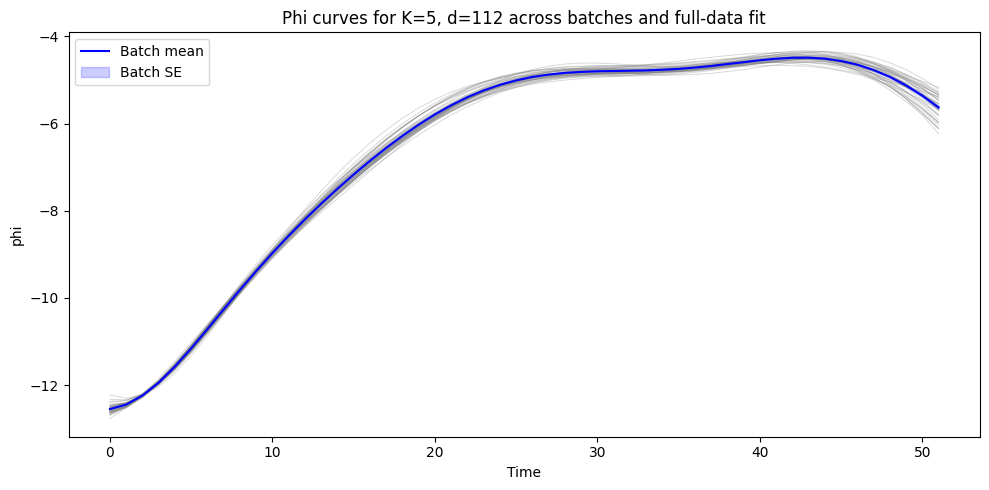

In [11]:
import matplotlib.pyplot as plt
import numpy as np

full_phi = phi_total

k = 5
d = 112
T = all_phis.shape[-1]
n_batches = all_phis.shape[0]

phi_curves = all_phis[:, k, d, :]  # shape: (n_batches, T)
mean_phi = phi_curves.mean(axis=0)
se_phi = phi_curves.std(axis=0) / np.sqrt(n_batches)
phi_total_curve = full_phi[k, d, :]

plt.figure(figsize=(10, 5))
for b in range(n_batches):
    plt.plot(phi_curves[b], color='gray', alpha=0.3, linewidth=0.7)
plt.plot(mean_phi, color='blue', label='Batch mean')
#plt.plot(mean_phi2, color='green', label='Batch mean enrolledata')
plt.fill_between(np.arange(T), mean_phi - se_phi, mean_phi + se_phi, color='blue', alpha=0.2, label='Batch SE')
#plt.plot(phi_total_curve, color='red', linewidth=2, label='Full-data phi')
plt.title(f'Phi curves for K={k}, d={d} across batches and full-data fit')
plt.xlabel('Time')
plt.ylabel('phi')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Calculate standard errors for all K and D combinations
K = all_phis.shape[1]  # number of signatures
D = all_phis.shape[2]  # number of diseases (348)
T = all_phis.shape[3]  # number of time points
n_batches = all_phis.shape[0]

# Calculate SE for all combinations
all_ses = []
for k in range(K):
    for d in range(D):
        phi_curves = all_phis[:, k, d, :]  # shape: (n_batches, T)
        se_phi = phi_curves.std(axis=0) / np.sqrt(n_batches)
        all_ses.extend(se_phi)  # Add all time points for this k,d combo

all_ses = np.array(all_ses)

# Summary statistics
print(f"Standard Error Summary (across all K={K} signatures, D={D} diseases, T={T} time points):")
print(f"Mean SE: {all_ses.mean():.4f}")
print(f"Median SE: {np.median(all_ses):.4f}")
print(f"Max SE: {all_ses.max():.4f}")
print(f"Min SE: {all_ses.min():.4f}")
print(f"95th percentile SE: {np.percentile(all_ses, 95):.4f}")
print(f"99th percentile SE: {np.percentile(all_ses, 99):.4f}")

Standard Error Summary (across all K=21 signatures, D=348 diseases, T=52 time points):
Mean SE: 0.0010
Median SE: 0.0002
Max SE: 0.0695
Min SE: 0.0000
95th percentile SE: 0.0036
99th percentile SE: 0.0182


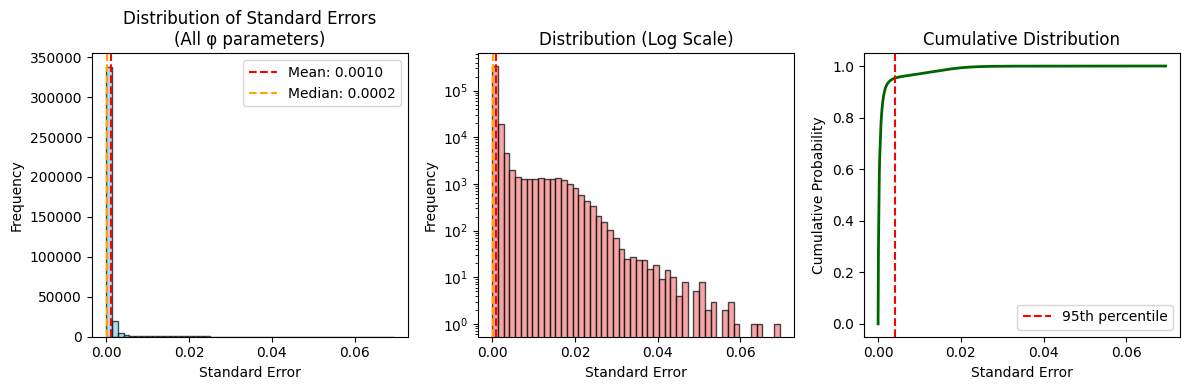

In [13]:
plt.figure(figsize=(12, 4))

# Subplot 1: Histogram of all SEs
plt.subplot(1, 3, 1)
plt.hist(all_ses, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Standard Error')
plt.ylabel('Frequency')
plt.title('Distribution of Standard Errors\n(All φ parameters)')
plt.axvline(np.mean(all_ses), color='red', linestyle='--', label=f'Mean: {np.mean(all_ses):.4f}')
plt.axvline(np.median(all_ses), color='orange', linestyle='--', label=f'Median: {np.median(all_ses):.4f}')
plt.legend()

# Subplot 2: Log scale histogram
plt.subplot(1, 3, 2)
plt.hist(all_ses[all_ses > 0], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Standard Error')
plt.ylabel('Frequency')
plt.title('Distribution (Log Scale)')
plt.yscale('log')
plt.axvline(np.mean(all_ses), color='red', linestyle='--')
plt.axvline(np.median(all_ses), color='orange', linestyle='--')

# Subplot 3: Cumulative distribution
plt.subplot(1, 3, 3)
sorted_ses = np.sort(all_ses)
plt.plot(sorted_ses, np.arange(len(sorted_ses))/len(sorted_ses), linewidth=2, color='darkgreen')
plt.xlabel('Standard Error')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution')
plt.axvline(0.004, color='red', linestyle='--', label='95th percentile')
plt.legend()

plt.tight_layout()
plt.show()

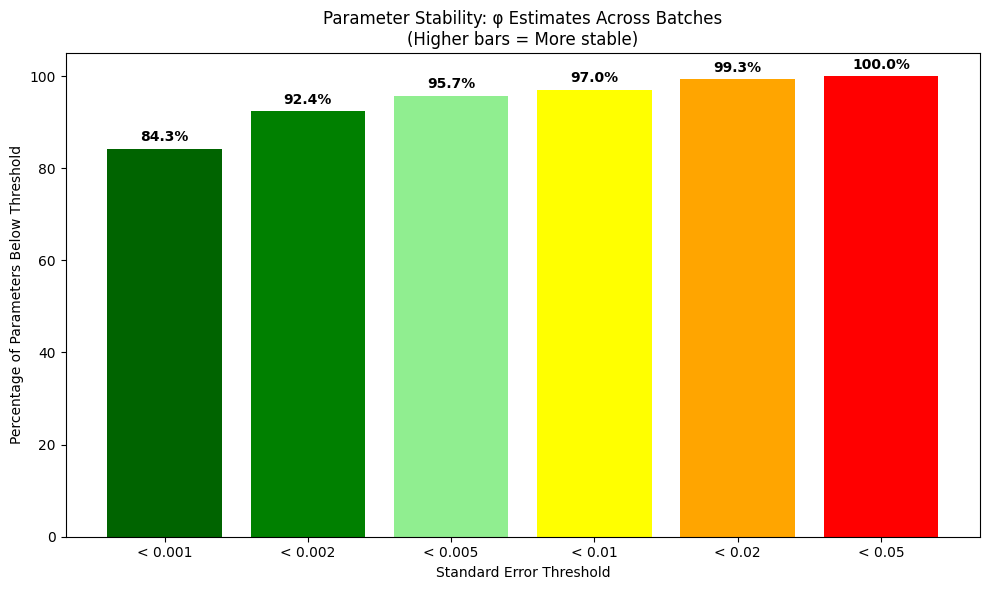

In [14]:
plt.figure(figsize=(10, 6))
thresholds = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]
percentages = [np.mean(all_ses < t) * 100 for t in thresholds]

plt.bar(range(len(thresholds)), percentages, color=['darkgreen', 'green', 'lightgreen', 'yellow', 'orange', 'red'])
plt.xlabel('Standard Error Threshold')
plt.ylabel('Percentage of Parameters Below Threshold')
plt.title('Parameter Stability: φ Estimates Across Batches\n(Higher bars = More stable)')
plt.xticks(range(len(thresholds)), [f'< {t}' for t in thresholds])

# Add percentage labels on bars
for i, v in enumerate(percentages):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, 105)
plt.tight_layout()
plt.show()

In [ ]:
# Pick a few random indices to check
indices_to_check = [0, 1, 2]  # or use np.random.choice(N, 3, replace=False)

for idx in indices_to_check:
    t = int(enrollment_ages[idx] - 30)
    print(f"\nPerson {idx} (enrollment age: {enrollment_ages[idx]}, t={t}):")
    for k in range(years_to_use):
        # Value from assembled array
        val_from_cox = pi_full[idx, 0, t+k].item()  # disease 0 as example
        # Value from batch file
        val_from_batch = pi_batches[k][idx, 0, t + k].item() if t + k < T else float('nan')
        print(f"  Year {k}: pi_full={val_from_cox:.6f}, pi_batch={val_from_batch:.6f}, match={np.isclose(val_from_cox, val_from_batch, atol=1e-6)}")

In [ ]:
import torch
import numpy as np
import pandas as pd

# Test function to verify age-specific censoring
def test_age_specific_censoring(E_100k, fh_processed, age_offset=5, test_patients=5):
    """
    Test that E_age_specific is correctly updated to reflect row.age + offset - 30
    """
    print(f"\n=== Testing Age-Specific Censoring (offset = {age_offset}) ===")
    
    # Create original and age-specific versions
    E_original = E_100k.clone()
    E_age_specific = E_100k.clone()
    
    # Get subset of patient data
    pce_df_subset = fh_processed.iloc[0:10000].reset_index(drop=True)
    
    # Apply age-specific censoring
    for patient_idx, row in enumerate(pce_df_subset.itertuples()):
        if patient_idx >= E_age_specific.shape[0]:
            break
            
        # Current age = enrollment age + age_offset
        current_age = row.age + age_offset
        
        # Time since age 30 for this current age
        time_since_30 = max(0, current_age - 30)
        
        # Cap event times to current age
        E_age_specific[patient_idx, :] = torch.minimum(
            E_age_specific[patient_idx, :],
            torch.full_like(E_age_specific[patient_idx, :], time_since_30)
        )
    
    # Test specific patients
    print(f"\nTesting first {test_patients} patients:")
    print("=" * 80)
    
    for i in range(min(test_patients, len(pce_df_subset))):
        row = pce_df_subset.iloc[i]
        
        enrollment_age = row.age
        current_age = enrollment_age + age_offset
        expected_cap = max(0, current_age - 30)
        
        # Get original and modified event times for this patient
        original_times = E_original[i, :].numpy()
        modified_times = E_age_specific[i, :].numpy()
        
        # Check if any times were actually capped
        times_changed = ~np.isclose(original_times, modified_times)
        
        print(f"\nPatient {i}:")
        print(f"  Enrollment age: {enrollment_age}")
        print(f"  Current age (enrollment + {age_offset}): {current_age}")
        print(f"  Expected cap (current_age - 30): {expected_cap}")
        print(f"  Times changed: {times_changed.sum()}/{len(times_changed)} diseases")
        
        if times_changed.any():
            # Show some examples of changed times
            changed_indices = np.where(times_changed)[0][:3]  # First 3 changes
            print(f"  Example changes:")
            for idx in changed_indices:
                print(f"    Disease {idx}: {original_times[idx]:.1f} → {modified_times[idx]:.1f}")
        
        # Show unchanged diseases and their values
        unchanged_indices = np.where(~times_changed)[0]
        if len(unchanged_indices) > 0:
            print(f"  Unchanged diseases (indices): {unchanged_indices[:5]}")  # Show first 5
            print(f"  Their original times: {original_times[unchanged_indices[:5]]}")
            print(f"  Their modified times: {modified_times[unchanged_indices[:5]]}")
            print(f"  DEBUG - E_original values: {E_original[i, unchanged_indices[:5]].numpy()}")
            print(f"  DEBUG - E_age_specific values: {E_age_specific[i, unchanged_indices[:5]].numpy()}")
        
        # Verify all modified times are <= expected cap
        all_capped_correctly = np.all(modified_times <= expected_cap + 1e-6)  # small tolerance
        print(f"  All times correctly capped: {all_capped_correctly}")
        
        # Check that no times increased
        no_times_increased = np.all(modified_times <= original_times + 1e-6)
        print(f"  No times increased: {no_times_increased}")
    
    return E_original, E_age_specific

# Example usage:
E_orig, E_modified = test_age_specific_censoring(E_100k, fh_processed, age_offset=5)

# Additional verification function
def compare_age_offsets(E_100k, fh_processed, patient_idx=0):
    """
    Show how one patient's event times change across different age offsets
    """
    print(f"\n=== Patient {patient_idx} Across Different Age Offsets ===")
    
    row = fh_processed.iloc[patient_idx]
    enrollment_age = row.age
    
    print(f"Enrollment age: {enrollment_age}")
    print(f"Original event times (first 5 diseases): {E_100k[patient_idx, :5].numpy()}")
    print()
    
    for age_offset in [0, 2, 5, 10]:
        E_test = E_100k.clone()
        current_age = enrollment_age + age_offset
        time_since_30 = max(0, current_age - 30)
        
        E_test[patient_idx, :] = torch.minimum(
            E_test[patient_idx, :],
            torch.full_like(E_test[patient_idx, :], time_since_30)
        )
        
        print(f"Age offset {age_offset:2d} (age {current_age:2.0f}, cap at {time_since_30:2.0f}): {E_test[patient_idx, :5].numpy()}")

# Example usage:
compare_age_offsets(E_100k, fh_processed, patient_idx=0)

In [ ]:
import torch
import numpy as np
import pandas as pd
fh_processed=pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox/baselinagefamh.csv')
len(fh_processed)
# Load your assembled full array
pi_full = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_full_leakage_free_20000_30000.pt")  # or pi_test_full.pt
# Load all batch arrays into a list
pi_batches = [
    torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age_offset_{k}_sex_20000_30000.pt")  # update path/pattern
    for k in range(10)
]
pce_df_subset = fh_processed.iloc[20000:30000].reset_index(drop=True)

# Enrollment ages for your cohort
enrollment_ages = pce_df_subset['age'].to_numpy()  # or whatever your DataFrame is

# Parameters
N, D, T = pi_full.shape
years_to_use = 10

# Pick a few random indices to check
np.random.seed(42)
indices_to_check = np.random.choice(N, 3, replace=False)
diseases_to_check = np.random.choice(D, 2, replace=False)
years_to_check = [0, 3, 7]  # e.g., enrollment, +3, +7 years

for idx in indices_to_check:
    t_enroll = int(enrollment_ages[idx] - 30)
    print(f"\nPerson {idx} (enrollment age: {enrollment_ages[idx]}, t_enroll: {t_enroll}):")
    for d in diseases_to_check:
        for k in years_to_check:
            t_full = t_enroll + k
            if t_full < T:
                val_full = pi_full[idx, d, t_full].item()
                val_batch = pi_batches[k][idx, d, t_full].item()
                print(f"  Disease {d}, year {k} after enrollment (t={t_full}): full={val_full:.6g}, batch={val_batch:.6g}, match={np.isclose(val_full, val_batch)}")

In [2]:
phi_total = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_model_W0.0001_fulldata_sexspecific.pt')['model_state_dict']['phi']

NameError: name 'torch' is not defined

In [ ]:
import torch
import numpy as np
import pandas as pd
fh_processed=pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox/baselinagefamh.csv')
len(fh_processed)
# Load your assembled full array
pi_full = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_full_leakage_free_0_10000.pt")  # or pi_test_full.pt
# Load all batch arrays into a list
pi_batches = [
    torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age_offset_{k}_sex_0_10000.pt")  # update path/pattern
    for k in range(10)
]
pce_df_subset = fh_processed.iloc[0:10000].reset_index(drop=True)

# Enrollment ages for your cohort
enrollment_ages = pce_df_subset['age'].to_numpy()  # or whatever your DataFrame is

# Parameters
N, D, T = pi_full.shape
years_to_use = 10

# Pick a few random indices to check
np.random.seed(42)
indices_to_check = np.random.choice(N, 3, replace=False)
diseases_to_check = np.random.choice(D, 2, replace=False)
years_to_check = [0, 3, 7]  # e.g., enrollment, +3, +7 years

for idx in indices_to_check:
    t_enroll = int(enrollment_ages[idx] - 30)
    print(f"\nPerson {idx} (enrollment age: {enrollment_ages[idx]}, t_enroll: {t_enroll}):")
    for d in diseases_to_check:
        for k in years_to_check:
            t_full = t_enroll + k
            if t_full < T:
                val_full = pi_full[idx, d, t_full].item()
                val_batch = pi_batches[k][idx, d, t_full].item()
                print(f"  Disease {d}, year {k} after enrollment (t={t_full}): full={val_full:.6g}, batch={val_batch:.6g}, match={np.isclose(val_full, val_batch)}")